# Data
- movie_ratings_500_id.pkl contains the interactions between users and movies
- movie_metadata.pkl contains detailed information about movies, e.g. genres, actors and directors of the movies.

# Goal

- Construct your own recommender systems
- Compare the performances of at least one of the baselines



# Baselines

## User-Based Collaborative Filtering
This approach predicts $\hat{r}_{(u,i)}$ by leveraging the ratings given to $i$ by $u$'s similar users. Formally, it is written as:

\begin{equation}
\hat{r}_{(u,i)} = \frac{\sum\limits_{v \in \mathcal{N}_i(u)}sim_{(u,v)}r_{vi}}{\sum\limits_{v \in \mathbf{N}_i(u)}|sim_{(u,v)}|}
\end{equation}
where $sim_{(u,v)}$ is the similarity between user $u$ and $v$. Usually, $sim_{(u,v)}$ can be computed by Pearson Correlation or Cosine Similarity.

## Item-Based Collaborative Filtering
This approach exploits the ratings given to similar items by the target user. The idea is formalized as follows:

\begin{equation}
\hat{r}_{(u,i)} = \frac{\sum\limits_{j \in \mathcal{N}_u(i)}sim_{(i,j)}r_{uj}}{\sum\limits_{j \in \mathbf{N}_u(i)}|sim_{(i,j)}|}
\end{equation}
where $sim_{(i,j)}$ is the similarity between item $i$ and $j$. Usually, $sim_{(i,j)}$ can be computed by Pearson Correlation or Cosine Similarity.

## Vanilla MF (You may use the package Surprise if you do not want to write the training function by your self)
Vanilla MF is the inner product of vectors that represent users and items. Each user is represented by a vector $\textbf{p}_u \in \mathbb{R}^d$, each item is represented by a vector $\textbf{q}_i \in \mathbb{R}^d$, and $\hat{r}_{(u,i)}$ is computed by the inner product of $\textbf{p}_u $ and $\textbf{q}_i$. The core idea of Vanilla MF is depicted in the followng figure and follows the idea of SVD as we have seen during the TD.

![picture](https://drive.google.com/uc?export=view&id=1EAG31Qw9Ti6hB7VqdONUlijWd4rXVobC)

\begin{equation}
\hat{r}_{(u,i)} = \textbf{p}_u{\textbf{q}_i}^T
\end{equation}

## Some variants of SVD



-  SVD with bias: $\hat{r_{ui}} = \mu + b_u + b_i + {q_i}^Tp_u$
- SVD ++: $\hat{r_{ui}} = \mu + b_u + b_i + {q_i}^T(p_u + |I_u|^{\frac{-1}{2}}\sum\limits_{j \in I_u}y_j)$

## Factorization machine (FM)

FM takes into account user-item interactions and other features, such as users' contexts and items' attributes. It captures the second-order interactions of the vectors representing these features , thereby enriching FM's expressiveness. However, interactions involving less relevant features may introduce noise, as all interactions share the same weight. e.g. You may use FM to consider the features of items.

\begin{equation}
\hat{y}_{FM}(\textbf{X}) = w_0 + \sum\limits_{j =1}^nw_jx_j + \sum\limits_{j=1}^n\sum\limits_{k=j+1}^n\textbf{v}_j^T\textbf{v}_kx_jx_k
\end{equation}

where $\textbf{X} \in \mathbb{R}^n$ is the feature vector, $n$ denotes the number of features, $w_0$ is the global bias, $w_j$ is the bias of the $j$-th feature and $\textbf{v}_j^T\textbf{v}_k$ denotes the bias of interaction between $j$-th feature and $k$-th feature, $\textbf{v}_j \in \mathbb{R}^d$ is the vector representing $j$-th feature.

## MLP

You may also represent users and items by vectors and them feed them into a MLP to make prediction.

## Metrics

- \begin{equation}
RMSE = \sqrt{\frac{1}{|\mathcal{T}|}\sum\limits_{(u,i)\in\mathcal{T}}{(\hat{r}_{(u,i)}-r_{ui})}^2}
\end{equation}

- \begin{equation}
MAE = \frac{1}{|\mathcal{T}|}\sum\limits_{(u,i)\in\mathcal{T}}{|\hat{r}_{(u,i)}-r_{ui}|}
\end{equation}
-  Bonnus: you may also consider NDCG and HR under the top-k setting



# Baselines implementation #

En terme de baselines, nous avons décidé d'implémenter les deux types de filrage collaboratif. Nous avons commencé par créer un modèle item based qui fonctionnerai pour un utilisateur donné, puis nous avons implémenté de manière plus générale les filtrages user-based et item-based, pour lesquels nous avons préféré calculer les RMSE. 

# Imports packages and data

In [1]:
import pandas as pd
import pickle
from scipy.stats import pearsonr
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
movie_metadata_path = 'movie_metadata.pkl'
movie_rating_path = "movie_ratings_500_id.pkl"

with open(movie_metadata_path, 'rb') as file:
    data_movie_metadata = pickle.load(file)
    
with open(movie_rating_path, 'rb') as file:
    data_movie_rating = pickle.load(file)
    


# Experimentations baseline pour un user

In [4]:
all_users = set()
all_movies = set()
user_rating = {}
for key, value in data_movie_rating.items():
    all_movies.add(key)
    for user in value:
        all_users.add(user["user_id"])
        if user["user_id"] not in user_rating.keys():
            user_rating[user["user_id"]] = dict()
        user_rating[user["user_id"]][key] = user["user_rating"]
target_user = user_rating.pop('1270217')
#1270217 = user_id étududié choisi au hasard


In [5]:
#Creating movie_ratings dict with the following structure:
#  movie_id : {user_id_1 : rating, ... , user_id_n : rating}
movie_ratings = {}
for key, value in data_movie_rating.items():
    if key not in movie_ratings.keys():
            movie_ratings[key] = {}
    for user in value:
        # Nous n'incluons pas le user que nous voulons étudier
        if user["user_id"] == "1270217":
            continue
        
        movie_ratings[key][user["user_id"]] = user["user_rating"]


In [6]:
#fonction de calcul de la similarité entre deux films
def item_similarity (id_movie1, id_movie2):
    movie1_rating = movie_ratings[id_movie1]
    movie2_rating = movie_ratings[id_movie2]
    
    #arrays pour pearson coef
    movie1 = []
    movie2 = []
    
    for user_id, user_rating in movie1_rating.items():
        if user_id in movie2_rating.keys():
            movie1.append((int)(user_rating))
            movie2.append((int)(movie2_rating[user_id]))
    
    if len(movie1) <= 4:
        return -2
    
    pearson_coef, _ = pearsonr(movie1, movie2)
    return pearson_coef

In [8]:
# fonction de calcul du item based collaboratiev filtering pour un film
def item_based_rec(user_id, movie_id):
    rating_prev = 0
    num = 0.0
    den = 0.0
    for movie in target_user.keys():
        if np.isnan(item_similarity(movie_id, movie)):
            continue
        num += item_similarity(movie_id, movie) * (float)(target_user[movie])
        den += abs(item_similarity(movie_id, movie))
    
    return num/den
        

In [9]:
print(item_based_rec("1270217", "tt0284491"))

-1.9131888146236826


C:\Users\guill\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
#application a notre user
predicted_grades = {}
for movie in all_movies:
    if movie not in target_user.keys():
        predicted_grades[movie] = item_based_rec("1270217", movie)
        

In [11]:
# Affichons les résultats pour un user donné
for key, value in sorted(predicted_grades.items(), key=lambda x: x[1], reverse=True):
    print(f"{key}, {value}\n")

tt0298408, 3.1163903794029175

tt0285823, 3.0824761605337834

tt0196229, 3.069089172165917

tt0289043, 3.0527865760314477

tt0307901, 3.03159930519613

tt0237572, 3.004085209279802

tt0138524, 2.988649332670158

tt0120824, 2.9650803271547037

tt0278731, 2.9518435387323385

tt0247199, 2.910980187192841

tt0310910, 2.896237796091233

tt0172493, 2.894827146644138

tt0274812, 2.88884843890575

tt0212720, 2.8736510480152573

tt0278504, 2.87284029131476

tt0276751, 2.8690717961058128

tt0376541, 2.8659450067661845

tt0253556, 2.863428530060194

tt0120780, 2.8541213653646267

tt0181536, 2.8346570789450745

tt0181984, 2.8326041265973605

tt0155975, 2.8287001715532276

tt0279331, 2.826363429991482

tt0246578, 2.8250891611644984

tt0270288, 2.8212434076186015

tt0278500, 2.8107159619542936

tt0139654, 2.8104692066495476

tt0172396, 2.809516517079166

tt0208092, 2.8001513017456734

tt0241303, 2.7997502457090064

tt0359423, 2.7948667313329953

tt0202677, 2.7936593761403947

tt0181875, 2.7922324045

In [12]:
#We need to transform the data
import pandas as pd
target_id = "1270217"
data_list = []

for key, value in user_rating.items():
    for item, rating in value.items():
        data_list.append({"user_id": key, "item_id": item, "rating": rating})

for key, value in target_user.items():
    data_list.append({"user_id": target_id, "item_id": key, "rating": value})
        
data = pd.DataFrame(data_list)

data.head(10)

,user_id,item_id,rating
0,1380819,tt0305224,4
1,1380819,tt0196229,5
2,1380819,tt0261392,4
3,1380819,tt0279113,4
4,1380819,tt0237534,5
5,1380819,tt0215750,4
6,1380819,tt0120669,3
7,1380819,tt0356150,5
8,1380819,tt0250494,5
9,1380819,tt0295178,4


In [13]:
users = set(data['user_id'])
movies = set(data["item_id"])

users_assoc = data["user_id"].value_counts().to_dict()
item_assoc = data["item_id"].value_counts().to_dict()

In [14]:
#Wen only want to keep users who voted for at least 10 films
to_keep = []
for key, value in users_assoc.items():
    if value >= 10:
         to_keep.append(key)

filtered_data = data[data["user_id"].isin(to_keep)]

# User based

In [15]:
ratings = filtered_data.copy()

train_data, test_data = train_test_split(ratings, test_size=0.2)

train_data['rating'] = train_data['rating'].astype(float)
test_data['rating'] = test_data['rating'].astype(float)

ratings_matrix = train_data.pivot_table(index='user_id', columns='item_id', values='rating')

#Using pearson to compute corr btwn users
movie_similarity = ratings_matrix.corr(method='pearson', min_periods=5)

def predict(ratings_matrix, similarity_matrix):
    pred = ratings_matrix.dot(similarity_matrix) / np.abs(similarity_matrix).sum(axis=1)
    return pred

movie_prediction = predict(ratings_matrix, movie_similarity)

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return np.sqrt(mean_squared_error(prediction, ground_truth))

test_ratings_matrix = test_data.pivot_table(index='user_id', columns='item_id', values='rating').fillna(0)

error = rmse(np.array(movie_prediction.fillna(0)), np.array(test_ratings_matrix))

print(f"Le RMSE du modèle est : {error}")


Le RMSE du modèle est : 3.5294660048526634


# Item based

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

ratings = filtered_data.copy()

train_data, test_data = train_test_split(ratings, test_size=0.2)

train_data['rating'] = train_data['rating'].astype(float)
test_data['rating'] = test_data['rating'].astype(float)

#Using transpose() because item based
ratings_matrix = train_data.pivot_table(index='user_id', columns='item_id', values='rating').transpose()


movie_similarity = ratings_matrix.corr(method='pearson', min_periods=5)

def predict(ratings_matrix, similarity_matrix):
    pred = ratings_matrix.dot(similarity_matrix) / np.abs(similarity_matrix).sum(axis=1)
    return pred

movie_prediction = predict(ratings_matrix, movie_similarity)

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return np.sqrt(mean_squared_error(prediction, ground_truth))

test_ratings_matrix = test_data.pivot_table(index='user_id', columns='item_id', values='rating').transpose().fillna(0)

error = rmse(np.array(movie_prediction.fillna(0)), np.array(test_ratings_matrix))

print(f"Le RMSE du modèle est : {error}")


Le RMSE du modèle est : 3.5280790586756243


## Les RMSE des deux baselines implémentées sont:
    - User based: 3.5231101971589425
    - Item based: 3.5326964299363293

### Comme indiqué dans la consigne, nous comparerons les résultats de nos modèles avec ***au moins 1 des baselines***, ici les deux que nous avons implémentés ###

# Modèles vus en cours

Nous avons ensuite implémenté plusieurs modèles étudiés ou évoqués en classe. Nous avons commencé par implémenter la méthode SVD comme vue en TP, suivi de la méthode d'arbre de décision, d'un réseau de neuronne avec TensorFlow et d'une méthode de forêt aléatoire. Les 4 méthodes obtiennent des RMSE meilleurs que ceux des deux baselines.

# SVD

In [17]:
len_users = filtered_data['user_id'].nunique()
len_items = filtered_data['item_id'].nunique()

user_id_map = {user_id: i for i, user_id in enumerate(filtered_data['user_id'].unique())}
item_id_map = {item_id: i for i, item_id in enumerate(filtered_data['item_id'].unique())}

matrix = np.zeros((len_users, len_items))

for row in filtered_data.itertuples():
    user_id = user_id_map[row[1]]
    item_id = item_id_map[row[2]]
    matrix[user_id, item_id] = row[3]

matrix.shape

(5128, 528)

In [18]:
zeros = 0
for row in matrix:
    for col in row:
        if col == 0:
            zeros += 1

print(f"Nb de zeros: {zeros}, Spasité: {zeros/(5128*528)}")

Nb de zeros: 2514503, Spasité: 0.9286888236893112


In [19]:
len_users = filtered_data['user_id'].nunique()
len_items = filtered_data['item_id'].nunique()

user_id_map = {user_id: i for i, user_id in enumerate(filtered_data['user_id'].unique())}
item_id_map = {item_id: i for i, item_id in enumerate(filtered_data['item_id'].unique())}
print(user_id_map)

{'1380819': 0, '185150': 1, '1351377': 2, '386143': 3, '2173336': 4, '716091': 5, '671513': 6, '1227848': 7, '712664': 8, '1907667': 9, '69867': 10, '1402412': 11, '1601783': 12, '2640108': 13, '306466': 14, '90246': 15, '1966165': 16, '2581879': 17, '2201376': 18, '2469958': 19, '422507': 20, '1476213': 21, '2407624': 22, '2336678': 23, '2480084': 24, '452013': 25, '754082': 26, '946164': 27, '388088': 28, '276813': 29, '2472268': 30, '539735': 31, '66568': 32, '1468812': 33, '132390': 34, '886716': 35, '1281187': 36, '1212306': 37, '205618': 38, '1778432': 39, '1844276': 40, '2422178': 41, '2557878': 42, '393953': 43, '120539': 44, '2289614': 45, '1052739': 46, '1950307': 47, '1441691': 48, '2422606': 49, '1208186': 50, '1017673': 51, '1829027': 52, '948797': 53, '2596225': 54, '175214': 55, '998229': 56, '30878': 57, '1515501': 58, '181323': 59, '1992490': 60, '2445646': 61, '921064': 62, '1910881': 63, '2308631': 64, '753886': 65, '670715': 66, '1770762': 67, '2079291': 68, '169364

In [20]:
mapped_data = filtered_data.copy()

user_id_map = {user_id: i + 1 for i, user_id in enumerate(mapped_data['user_id'].unique())}
mapped_data['user_id'] = mapped_data['user_id'].map(user_id_map)

item_id_map = {item_id: i + 1 for i, item_id in enumerate(mapped_data['item_id'].unique())}
mapped_data['item_id'] = mapped_data['item_id'].map(item_id_map)

print(mapped_data)

        user_id  item_id rating
0             1        1      4
1             1        2      5
2             1        3      4
3             1        4      4
4             1        5      5
...         ...      ...    ...
259813     5128      340      2
259814     5128      255      4
259815     5128      233      3
259816     5128      377      3
259817     5128      177      4

[193081 rows x 3 columns]


In [21]:
reverse_user_id_map = {v: k for k, v in user_id_map.items()}
reverse_item_id_map = {v: k for k, v in item_id_map.items()}

mapped_user_id = 1 # Replace with the mapped user ID you want to look up
original_user_id = reverse_user_id_map.get(mapped_user_id, None)

mapped_item_id = 1  #Replace with the mapped item ID you want to look up
original_item_id = reverse_item_id_map.get(mapped_item_id, None)

print(f"Original User ID for Mapped User ID {mapped_user_id}: {original_user_id}")
print(f"Original Item ID for Mapped Item ID {mapped_item_id}: {original_item_id}")

Original User ID for Mapped User ID 1: 1380819
Original Item ID for Mapped Item ID 1: tt0305224


In [22]:
mapped_data.to_csv("ratings.data", sep="\t", index=False, header=False)

In [23]:
import pickle
import numpy as np
import matplotlib.pyplot as plt

data_path = "ratings.data"
class Funk_SVD:
    """
    Implement Funk_SVD
    """
    def __init__(self, path, USER_NUM, ITEM_NUM, FACTOR, EPOCHS:int=10, THETA:float=1e-4, ALPHA:float=0.002, BETA:float=0.02):
        super(Funk_SVD, self).__init__()
        self.path = path
        self.USER_NUM = USER_NUM
        self.ITEM_NUM = ITEM_NUM
        self.FACTOR = FACTOR
        self.EPOCHS = EPOCHS
        self.THETA = THETA
        self.ALPHA = ALPHA
        self.BETA = BETA
        self.init_model()

    def load_data(self, flag='train', sep='\t', random_state=0, size=0.8):
        np.random.seed(random_state)
        with open(self.path, 'r') as f:
            for index, row in enumerate(f):
                if index == 0:
                    continue
                rand_num = np.random.rand()
                if flag == 'train':
                    if rand_num < size:
                        u, i, r = row.strip('\r\n').split(sep)
                        yield (int(u) - 1, int(i) - 1, float(r))
                else:
                    if rand_num >= size:
                        u, i, r= row.strip('\r\n').split(sep)
                        yield (int(u) - 1, int(i) - 1, float(r))

    def init_model(self):
        '''
        Initialize matrices P and Q with np.random.rand
        '''
        self.P = np.random.rand(self.USER_NUM, self.FACTOR)/(self.FACTOR**0.5)
        self.Q = np.random.rand(self.ITEM_NUM, self.FACTOR)/(self.FACTOR**0.5)

    def train(self):
        '''
        Train the model
        epochs - number of iterations
        theta - threshold of iterations
        alpha - learning rate
        beta - parameter of regularization term

        Complete this function to update P and Q
        '''
        epochs, theta, alpha, beta = self.EPOCHS, self.THETA, self.ALPHA, self.BETA
        old_e = 0.0
        self.cost_of_epoch = []
        for epoch in range(epochs):
            #print(f"Current epoch is {epoch + 1}")
            current_e = 0.0
            train_data = self.load_data(flag='train')
            for index, d in enumerate(train_data):
                u, i, r = d
                pr = np.dot(self.P[u], self.Q[i])
                err = r - pr
                current_e += pow(err,2) # loss term
                self.P[u] += alpha * (err*self.Q[i]-beta*self.P[u])
                self.Q[i] += alpha * (err*self.P[u]-beta*self.Q[i])
                current_e += (beta/2)*(sum(pow(self.P[u],2)))+sum(pow(self.Q[i],2)) # regularization
            self.cost_of_epoch.append(current_e)
            #print(f'Cost is {current_e}')
            if abs(current_e - old_e) < theta:
                break
            old_e = current_e
            alpha *= 0.9

    def predict_rating(self, user_id, item_id):
        '''
        Predict rating for the target user of the target item

        user - the number of the user (user_id=xuhao-1)
        item - the number of the item (item_id=xuhao-1)
        Complete this function for prediction
        '''
        return np.dot(self.P[user_id], self.Q[item_id])

    def recommend_list(self, user, k=10):
        '''
        Recommend the top n movies for the target user. For rating prediction, recommend items with a rating above 4/5 of the maximum rating.
        '''
        user_id = user-1
        user_items = {}
        for item_id in range(self.ITEM_NUM):
            user_had_look = self.user_had_look_in_train()
            if item_id in user_had_look[user]:
                continue
            pr = self.predict_rating(user_id,item_id)
            user_items[item_id] = pr
            items = sorted(user_items.items(), key=lambda x:x[1],reverse=True)[:k]
        return items

    def user_had_look_in_train(self):
        '''
        Write a function that returns the movies that users have already watched in the past
        '''
        user_had_look = {}
        train_data = self.load_data(flag='train')
        for index, d in enumerate(train_data):
            u,i,r = d
            user_had_look.setdefault(u,{})
            user_had_look[u][i] = r
        return user_had_look

    def test_rmse(self):
        '''
        Test the model and return the RMSE value
        '''
        rmse = 0
        num = 0
        test_data = self.load_data(flag='test')
        for index, d in enumerate(test_data):
            num = index+1
            u,i,r = d
            pr = np.dot(self.P[u], self.Q[i])
            rmse += pow((r-pr),2)
        rmse = (rmse/num)**0.5
        return rmse

    def show(self):
        '''
        Create a function that plots the loss after each iteration
        '''
        nums=range(len(self.cost_of_epoch))
        plt.plot(nums, self.cost_of_epoch,label='cost value')
        plt.xlabel('# of epoch')
        plt.ylabel('cost')
        plt.legend()
        plt.show()

    def save_model(self):
        '''
        Save the model to pickle (P, Q, and RMSE)
        '''
        data_dict = {'P': self.P, 'Q': self.Q}
        f = open('funk-svd.pkl', 'wb')
        pickle.dump(data_dict, f)
        pass

    def read_model(self):
        '''
        Reload the model from the local disk
        '''
        f = open('funk-svd.pkl', 'rb')
        model = pickle.load(f)
        self.P = model['P']
        self.Q = model['Q']
        pass


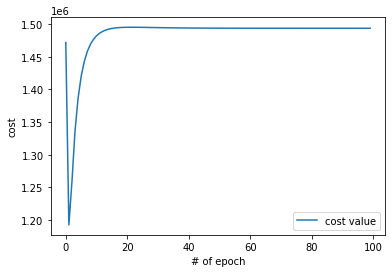

rmse: 0.9428063992259089


In [24]:
if __name__=="__main__":
    mf=Funk_SVD(data_path,5128,528,50,EPOCHS=100)#path,user_num,item_num,factor
    mf.train()
    mf.save_model()
    mf.show()
    rmse=mf.test_rmse()
    print("rmse:",rmse)

# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

combined_data = []
for movie_id, metadata in data_movie_metadata.items():
    if movie_id in data_movie_rating:
        for rating_info in data_movie_rating[movie_id]:
            combined_data.append({
                'movie_id': movie_id,
                'user_id': rating_info['user_id'],
                'genre': ', '.join(metadata['genre']),
                'actors': ', '.join(metadata['actors']),
                'director': metadata['director'],
                'rating': int(rating_info['user_rating'])
            })

df = pd.DataFrame(combined_data)

#Encode les string en valeurs numériques pour être interprétables
label_encoder = LabelEncoder()
df['movie_id_encoded'] = label_encoder.fit_transform(df['movie_id'])

# One-hot encode pour variables categorielles
encoder = OneHotEncoder(sparse=False, drop='first')
X_encoded = encoder.fit_transform(df[['genre', 'actors', 'director']])
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(['genre', 'actors', 'director']))

X = pd.concat([df[['user_id', 'movie_id_encoded', 'rating']], X_encoded_df], axis=1)

y = X['rating']
X = X.drop(['rating', 'movie_id_encoded'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

C:\Users\guill\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Root Mean Squared Error (RMSE): 1.4136827652691493


# Neural network

In [26]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Concatenate, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

combined_data = []
for movie_id, metadata in data_movie_metadata.items():
    if movie_id in data_movie_rating:
        for rating_info in data_movie_rating[movie_id]:
            combined_data.append({
                'movie_id': movie_id,
                'user_id': rating_info['user_id'],
                'genre': ', '.join(metadata['genre']),
                'actors': ', '.join(metadata['actors']),
                'director': metadata['director'],
                'rating': int(rating_info['user_rating'])
            })
ratings = pd.DataFrame(combined_data)

# Création de dict pour map les user et les movie IDs vers les indices numeriques
user_ids = ratings['user_id'].unique()
movie_ids = ratings['movie_id'].unique()

user_id_to_index = {original_id: index for index, original_id in enumerate(user_ids)}
movie_id_to_index = {original_id: index for index, original_id in enumerate(movie_ids)}

# Map les IDs originaux vers les indices numeriques
ratings['user_index'] = ratings['user_id'].map(user_id_to_index)
ratings['movie_index'] = ratings['movie_id'].map(movie_id_to_index)

mlb = MultiLabelBinarizer()
ratings['genre'] = ratings['genre'].apply(lambda x: x.split(', '))
ratings['actors'] = ratings['actors'].apply(lambda x: x.split(', '))

genres_encoded = pd.DataFrame(mlb.fit_transform(ratings['genre']), columns=mlb.classes_, index=ratings.index)
actors_encoded = pd.DataFrame(mlb.fit_transform(ratings['actors']), columns=mlb.classes_, index=ratings.index)

ratings = pd.concat([ratings, genres_encoded, actors_encoded], axis=1)

train, test = train_test_split(ratings, test_size=0.2, random_state=42)

embedding_size = 50

# Definition du nombre de valeurs uniques pour users, movies, et genres
num_users = len(user_ids)
num_movies = len(movie_ids)
num_genres = len(genres_encoded.columns)
num_actors = len(actors_encoded.columns)

user_input = Input(shape=(1,))
user_embedding = Embedding(num_users, embedding_size, input_length=1)(user_input)
user_vec = Flatten()(user_embedding)

movie_input = Input(shape=(1,))
movie_embedding = Embedding(num_movies, embedding_size, input_length=1)(movie_input)
movie_vec = Flatten()(movie_embedding)

genres_input = Input(shape=(num_genres,))
dense_layer_genres = Dense(embedding_size, activation='relu')(genres_input)

actors_input = Input(shape=(num_actors,))
dense_layer_actors = Dense(embedding_size, activation='relu')(actors_input)

concat = Concatenate()([movie_vec, dense_layer_genres, dense_layer_actors])
dense_layer_final = Dense(embedding_size, activation='relu')(concat)
output = Dense(1)(dense_layer_final)

prod = Dot(axes=1)([user_vec, dense_layer_final])

model = Model(inputs=[user_input, movie_input, genres_input, actors_input], outputs=prod)

model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

model.fit(
    [train['user_index'], train['movie_index'], train.iloc[:, -num_genres:], train.iloc[:, -num_actors:]],
    train['rating'],
    batch_size=128,
    epochs=5,
    validation_split=0.1
)

predictions = model.predict(
    [test['user_index'], test['movie_index'], test.iloc[:, -num_genres:], test.iloc[:, -num_actors:]]
)
rmse = np.sqrt(mean_squared_error(test['rating'], predictions))
print(f'RMSE: {rmse}')


C:\Users\guill\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
1462/1462 [==============================] - 31s 21ms/step - loss: 3.6190 - val_loss: 2.1596
Epoch 2/5
1462/1462 [==============================] - 30s 21ms/step - loss: 1.3400 - val_loss: 2.0950
Epoch 3/5
1462/1462 [==============================] - 27s 18ms/step - loss: 1.0851 - val_loss: 2.0436
Epoch 4/5
1462/1462 [==============================] - 27s 19ms/step - loss: 0.9413 - val_loss: 1.9686
Epoch 5/5
1624/1624 [==============================] - 2s 1ms/step
RMSE: 1.393368457953719


# Random forest (/!\  **prend 1h à run** /!\ ) 

### Root Mean Squared Error (RMSE): 1.1866020944040818 ###

In [27]:
# from sklearn.ensemble import RandomForestRegressor

# combined_data = []
# for movie_id, metadata in data_movie_metadata.items():
#     if movie_id in data_movie_rating:
#         for rating_info in data_movie_rating[movie_id]:
#             combined_data.append({
#                 'movie_id': movie_id,
#                 'user_id': rating_info['user_id'],
#                 'genre': ', '.join(metadata['genre']),
#                 'actors': ', '.join(metadata['actors']),
#                 'director': metadata['director'],
#                 'rating': int(rating_info['user_rating'])
#             })

# df = pd.DataFrame(combined_data)

# label_encoder = LabelEncoder()
# df['movie_id_encoded'] = label_encoder.fit_transform(df['movie_id'])

# encoder = OneHotEncoder(sparse=False, drop='first')
# X_encoded = encoder.fit_transform(df[['genre', 'actors', 'director']])
# X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names(['genre', 'actors', 'director']))

# X = pd.concat([df[['user_id', 'movie_id_encoded']], X_encoded_df], axis=1)
# y = df['rating']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model = RandomForestRegressor(random_state=42)
# model.fit(X_train, y_train)

# y_pred = model.predict(X_test)

# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print(f'Root Mean Squared Error (RMSE): {rmse}')

## Le meilleur RMSE parmi nos modèles est celui du SVD avec 0.942832491688615 ##
Nous remarquons donc que la méthode SVD est plus efficace en terme de recommandations de films pour des utilisateurs. Les abres et la forêt ne semblent pas être les modèmes les mieux adaptés à ce genre de problèmes. Il serait probablement possible d'améliorer les résultats du réseau de neurone mais à travers nos différents test nous avons remarqués que le nombre d'époch n'améliorait le RMSE que sur l'intervalle [1 - 5], puis qu'il le dégradait pous des valeurs plus élévées.

Le SVD donnant le meilleur résultat, nous utilisons donc le système de recommandation implémenté dans la classe


In [28]:
user_items=mf.recommend_list(user_id_map[target_id]-1)
print(user_items)

[(144, 3.630428768254514), (143, 3.6175344531333464), (498, 3.6163226100735466), (99, 3.5929169501247777), (154, 3.5663665144216115), (333, 3.5399534969145368), (230, 3.535543525656207), (267, 3.517910227119922), (33, 3.494486480886054), (151, 3.49255257564578)]


In [29]:
print(f"Recommandations for user n°{target_id}:\n")
for item in user_items:
    movie_id = reverse_item_id_map.get(item[0], None)
    print(f"Movie id: {movie_id}, Movie title: {data_movie_metadata[movie_id]['title']}")

Recommandations for user n°1270217:

Movie id: tt0372784, Movie title: Batman Begins
Movie id: tt0346156, Movie title: Sky Captain and the World of Tomorrow
Movie id: tt0342258, Movie title: Unleashed
Movie id: tt0234215, Movie title: The Matrix Reloaded
Movie id: tt0272338, Movie title: Punch-Drunk Love
Movie id: tt0175880, Movie title: Magnolia
Movie id: tt0315733, Movie title: 21 Grams
Movie id: tt0295297, Movie title: Harry Potter and the Chamber of Secrets
Movie id: tt0120755, Movie title: Mission: Impossible II
Movie id: tt0299172, Movie title: Home on the Range


# Requirements
- Minimizing the RMSE and MAE
- Try to compare different methods that you have adopted and interpret the results that you have obtained
- Construct a recommender system that returns the top 10 movies that the users have not watched in the past
- Before January 7th